# Neural Style Transfer with PyTorch

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [6]:
# Select the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [22]:
# Define the image loader
def image_loader(image_name, loader, device):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)


imsize = (512, 512) if torch.cuda.is_available() else (128, 128)

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

style_img = image_loader('starry_night.jpg', loader, device)
content_img = image_loader('tartaruga.jpg', loader, device)

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), 'We need to import style and content images of the same size'

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


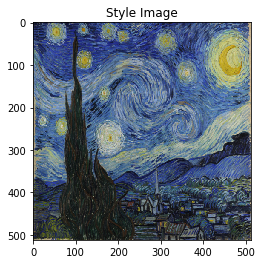

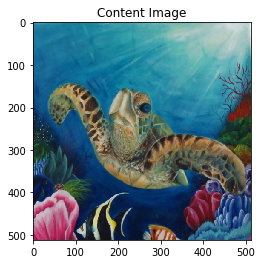

In [23]:
# Show the images to know if everything is all right

def imshow(tensor, unloader, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)

unloader = transforms.ToPILImage()

plt.figure()
imshow(style_img, unloader, title='Style Image')

plt.figure()
imshow(content_img, unloader, title='Content Image')

In [0]:
# Define the content loss

class ContentLoss(nn.Module):
  
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
    
  def forward(self, x):
    self.loss = F.mse_loss(x, self.target)
    return x


In [0]:
# Define the style loss

def gram_matrix(x):
  # a = batch size = 1
  # b = number of features map
  # (c, d) = dimensions of a f. map (N=c*d)
  a, b, c, d = x.size()
  
  features = x.view(a*b, c*d)
  
  G = torch.mm(features, features.t()) # gram matrix
  
  return G.div(a * b * c * d)


class StyleLoss(nn.Module):
  
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()
    
  def forward(self, x):
    G = gram_matrix(x)
    self.loss = F.mse_loss(G, self.target)
    return x
  

In [0]:
# Import the VGG19 network
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [0]:
# Normalize the style and content images with the VGG parameters

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Create a module to normalize input image

class Normalization(nn.Module):
  
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)
    
  def forward(self, img):
    return (img - self.mean) / self.std

In [0]:
# Desired depth layers to compute content/style loss

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img,
                              content_layers=content_layers_default, style_layers=style_layers_default):
  cnn = copy.deepcopy(cnn)
  
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  
  content_losses = []
  style_losses = []
  
  model = nn.Sequential(normalization)
  
  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
      
    model.add_module(name, layer)
    
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)
      
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module('style_loss_{}'.format(i), style_loss)
      style_losses.append(style_loss)
      
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
      
  model = model[:(i + 1)]
  
  return model, style_losses, content_losses

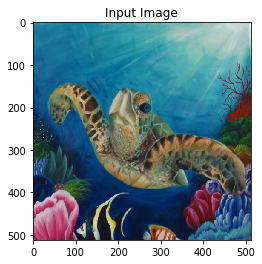

In [29]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, unloader, title='Input Image')

In [0]:
# Input optimizer

def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [0]:
# Style transfer

def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img,
                      num_steps=300, style_weight=1000000, content_weight=1):
  print('Building the style transfer model...')
  model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean,
                                                                  normalization_std, style_img,
                                                                  content_img)
  optimizer = get_input_optimizer(input_img)
  
  print('Optimizing...')
  run = [0]
  while run[0] <= num_steps:
    
    def closure():
      input_img.data.clamp_(0, 1)
      
      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0
      
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score = cl.loss
      
      style_score *= style_weight
      content_score *= content_weight
      
      loss = style_score + content_score
      loss.backward()
      
      run[0] += 1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
        print()
        
      return style_score + content_score
    
    optimizer.step(closure)
    
  input_img.data.clamp_(0, 1)
  
  return input_img

Building the style transfer model...
Optimizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


run [50]:
Style Loss : 12.263925 Content Loss: 15.177919

run [100]:
Style Loss : 2.525989 Content Loss: 13.248995

run [150]:
Style Loss : 1.510773 Content Loss: 11.349137

run [200]:
Style Loss : 1.179669 Content Loss: 10.398384

run [250]:
Style Loss : 0.955457 Content Loss: 9.854012

run [300]:
Style Loss : 0.811101 Content Loss: 9.495900



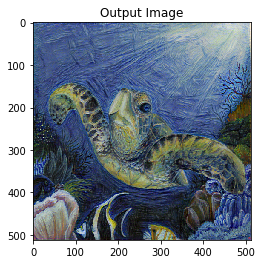

In [32]:
# Run the algorithm

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                           content_img, style_img, input_img)

plt.figure()
imshow(output, unloader, title='Output Image')

In [0]:
import numpy as np

out = output.cpu()
out = out.squeeze(0)
plt.imsave('output.jpg', np.array(unloader(out)))